# This notebook contains the following analysis:

1. Cross validation and gradient descent to determine optimal $\eta$
2. Stochastic gradient descent for OLS
3. Ridge regression and tunning $\lambda$ and $\eta$
4. SGD using Scikit-learn
5. Analytical Vs SGD


In [1]:
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import LinearReg as lreg
import sklearn.model_selection
import sklearn.metrics
import seaborn as sns
import os

In [2]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "/Users/endriasa/Projects/FYS4155/Project-2/Figures"
FIGURE_ID = "Figures"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", dpi=100,pad_inches=0.0,transparent=False, bbox_inches='tight',format='png')

## Cross validation and gradient descent to determine optimal $\eta$

In [3]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

lr = lreg.LinearReg()

# Generate noise and add it to Franke function
zz_0     = lr.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = lr.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = lr.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
X_train = lr.DesignDesign(x_train,y_train,degree)  
X_test  = lr.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# deleting the ones from the design matrix
#X_test  = np.delete(X_test, [0,1], axis=1) 
#X_train = np.delete(X_train, [0,1], axis=1)

# Hessian matrix
H = (2.0/len(z_train))* X_train.T @ X_train

# Get the eigenvalues
EigValues, _ = np.linalg.eig(H)
eta_max      = 1.0/np.max(EigValues)

# Set the learning rate, the number of iterations, and the regulirization parameter
eta    = np.array([0.001, 0.01, eta_max]) 
Niter  = np.int(1e4)

# Call the regression class and perform fitting
nk               = 5
z_folds, x_folds = lr.k_fold_reshaper(nk,z_train,X_train,shuffle=True)

loss_train    = np.zeros([Niter,len(eta)])
loss_test     = np.zeros([Niter,len(eta)])
MSE_GD_train  = np.zeros([len(eta),1])
MSE_GD_test   = np.zeros([len(eta),1])
R2_GD_train   = np.zeros([len(eta),1])
R2_GD_test    = np.zeros([len(eta),1])
MSE_OLS_train = 0.0
MSE_OLS_test  = 0.0
R2_OLS_train  = 0.0
R2_OLS_test   = 0.0

for i in range(nk):
    
    xk_train = x_folds[np.arange(len(x_folds))!=i]      
    xk_train = np.concatenate(xk_train,axis=0)
    zk_train = z_folds[np.arange(len(z_folds))!=i]
    zk_train = np.concatenate(zk_train,axis=0)
    xk_test  = x_folds[i]
    zk_test  = z_folds[i]
    
    for j in range(len(eta)):

        lr = lreg.LinearReg(eta = eta[j])
        cost_test, cost_train, axis, beta_GD, _ = lr.fit(xk_train, zk_train, xk_test, 
                                              zk_test, Niter, solver='gd')
        
        pred_GD_test  = lr.predict(xk_test)
        pred_GD_train = lr.predict(xk_train)  
        
        MSE_test  = lr.MSE(zk_test,pred_GD_test)
        MSE_train = lr.MSE(zk_train,pred_GD_train)
        R2_test   = lr.R2Score(zk_test,pred_GD_test)
        R2_train  = lr.R2Score(zk_train,pred_GD_train)
        
        loss_train[:,j]  += cost_train
        loss_test[:,j]   += cost_test
        MSE_GD_train[j]  += MSE_train
        MSE_GD_test[j]   += MSE_test
        R2_GD_train[j]   += R2_train
        R2_GD_test[j]    += R2_test
        
    #beta_OLS, pred_OLS_test, pred_OLS_train = lr.OridinaryLeastSquares(xk_train,zk_train,xk_test)   
    beta_OLS, pred_OLS_test, pred_OLS_train = lr.RidgeRegression(xk_train,zk_train,xk_test,1e-4)  
    
    MSE_testx  = lr.MSE(zk_test,pred_OLS_test)
    MSE_trainx = lr.MSE(zk_train,pred_OLS_train)
    R2_testx   = lr.R2Score(zk_test,pred_OLS_test)
    R2_trainx  = lr.R2Score(zk_train,pred_OLS_train)
    
    MSE_OLS_train += MSE_trainx
    MSE_OLS_test  += MSE_testx
    R2_OLS_train  += R2_trainx
    R2_OLS_test   += R2_testx
        
loss_train    = loss_train/nk
loss_test     = loss_test/nk
MSE_GD_train  = MSE_GD_train/nk
MSE_GD_test   = MSE_GD_test/nk   
R2_GD_train   = R2_GD_train/nk
R2_GD_test    = R2_GD_test/nk   
MSE_OLS_train = MSE_OLS_train/nk
MSE_OLS_test  = MSE_OLS_test/nk   
R2_OLS_train  = R2_OLS_train/nk
R2_OLS_test   = R2_OLS_test/nk   

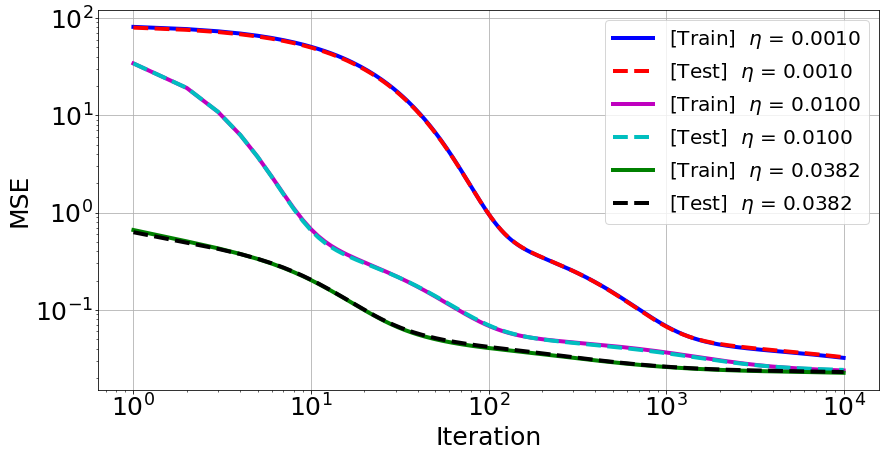

In [4]:
fig, ax = plt.subplots(figsize=(14,7))  
plt.loglog(axis, loss_train[:,0], 'b',linewidth=4,label="[Train] " + r" $\eta$ = %0.4f" %eta[0])
plt.loglog(axis, loss_test[:,0],'r--',linewidth=4,label="[Test] " + r" $\eta$ = %0.4f" %eta[0])
plt.loglog(axis, loss_train[:,1], 'm',linewidth=4,label="[Train] " + r" $\eta$ = %0.4f" %eta[1])
plt.loglog(axis, loss_test[:,1],'c--',linewidth=4,label="[Test] " + r" $\eta$ = %0.4f" %eta[1])
plt.loglog(axis, loss_train[:,2], 'g',linewidth=4,label="[Train] " + r" $\eta$ = %0.4f" %eta[2])
plt.loglog(axis, loss_test[:,2],'k--',linewidth=4,label="[Test] " + r" $\eta$ = %0.4f" %eta[2])
plt.legend(fontsize=25)
plt.grid()
plt.ylabel('MSE',fontsize=25)
plt.xlabel('Iteration',fontsize=25)
ax.tick_params(axis='x', which='major', labelsize=25,pad=1)
ax.tick_params(axis='y', which='major', labelsize=25,pad=1)
ax.legend(loc='best',fontsize=20)
save_fig('LinearReg_CV_eta_GD')
plt.show()

In [5]:
print('MSE OLS TEST',MSE_OLS_test)
print('MSE GD TEST',MSE_GD_test.T)
print('MSE OLS TRAIN',MSE_OLS_train)
print('MSE GD TRAIN',MSE_GD_train.T)

print('R2 OLS TEST',R2_OLS_test)
print('R2 GD TEST',R2_GD_test.T)
print('R2 OLS TRAIN',R2_OLS_train)
print('R2 GD TRAIN',R2_GD_train.T)

MSE OLS TEST 0.016967466938513035
MSE GD TEST [[0.03263102 0.02417211 0.02296296]]
MSE OLS TRAIN 0.016500926668028167
MSE GD TRAIN [[0.03212856 0.02384203 0.02255829]]
R2 OLS TEST 0.838342630006942
R2 GD TEST [[0.69058631 0.76964988 0.78114355]]
R2 OLS TRAIN 0.8438237681161371
R2 GD TRAIN [[0.69572771 0.77442616 0.78650724]]


## Stochastic gradient descent for OLS

In [6]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

lr = lreg.LinearReg()

# Generate noise and add it to Franke function
zz_0     = lr.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = lr.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = lr.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
#X_train = lr.DesignDesign(x_train,y_train,degree)  
#X_test  = lr.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Set the learning rate, the number of iterations, and the regulirization parameter
nxy        = X_train.shape[0]
eta        = 0.01
n_epochs   = [1000, 2500, 5000, 10000]
batch_size = [300, 400, 500, 600]
lr         = lreg.LinearReg(eta = eta,eta_type ='exp',eta_scal=False)

nk               = 5
z_folds, x_folds = lr.k_fold_reshaper(nk,z_train,X_train,shuffle=True)
MSE_SGD_train    = np.zeros((len(batch_size), len(n_epochs)))
MSE_SGD_test     = np.zeros((len(batch_size), len(n_epochs)))
R2_SGD_train     = np.zeros((len(batch_size), len(n_epochs)))
R2_SGD_test      = np.zeros((len(batch_size), len(n_epochs)))

for ik in range(nk):
    
    xk_train = x_folds[np.arange(len(x_folds))!=ik]      
    xk_train = np.concatenate(xk_train,axis=0)
    zk_train = z_folds[np.arange(len(z_folds))!=ik]
    zk_train = np.concatenate(zk_train,axis=0)
    xk_test  = x_folds[ik]
    zk_test  = z_folds[ik]
    jc       = 0

    for j in n_epochs:
    
        ic = 0
    
        for i in batch_size:
 
            cost_test, cost_train, axis, beta_GD, eta_vec = lr.fit(xk_train, zk_train, xk_test, 
                                              zk_test, Niter = j, batch_size = i,solver='sgd')
            pred_SGD_test  = lr.predict(xk_test)
            pred_SGD_train = lr.predict(xk_train)  
        
            MSE_test  = lr.MSE(zk_test,pred_SGD_test)
            MSE_train = lr.MSE(zk_train,pred_SGD_train)
            R2_test   = lr.R2Score(zk_test,pred_SGD_test)
            R2_train  = lr.R2Score(zk_train,pred_SGD_train)
        
            MSE_SGD_train[ic,jc] += MSE_train
            MSE_SGD_test[ic,jc]  += MSE_test
            R2_SGD_train[ic,jc]  += R2_train
            R2_SGD_test[ic,jc]   += R2_test
            ic                   += 1
            
        jc += 1
        
MSE_SGD_train  = MSE_SGD_train/nk
MSE_SGD_test   = MSE_SGD_test/nk   
R2_SGD_train   = R2_SGD_train/nk
R2_SGD_test    = R2_SGD_test/nk  

In [7]:
bb = np.array(batch_size)
ee = np.array(n_epochs)

bbin, eein = np.where(MSE_SGD_test  == np.min(MSE_SGD_test))
best_mbatch,best_epoch              = bb[bbin], ee[eein] 
bbin2, eein2 = np.where(R2_SGD_test == np.max(R2_SGD_test))
best_mbatch2,best_epoch2            = bb[bbin2], ee[eein2] 

print('MSE best = ',best_mbatch,best_epoch)
print('R2 best = ',best_mbatch2,best_epoch2)

MSE best =  [300] [5000]
R2 best =  [300] [5000]


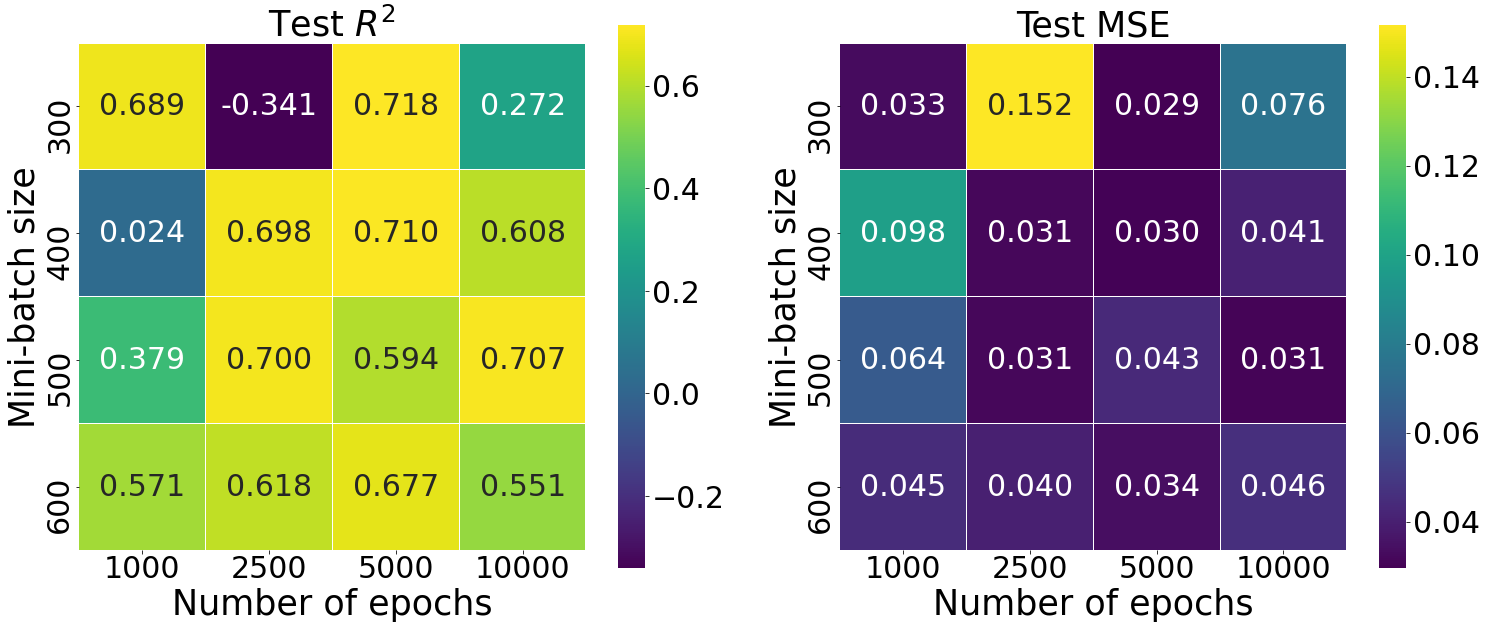

In [8]:
yticklabels = batch_size
xticklabels = n_epochs

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(R2_SGD_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel('Mini-batch size',fontsize=35);
plt.xlabel('Number of epochs',fontsize=35);
all_sample_title = r'Test $R^2$'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(MSE_SGD_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel('Mini-batch size',fontsize=35);
plt.xlabel('Number of epochs',fontsize=35);
all_sample_title = 'Test MSE'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
#save_fig('LinearReg_CV_linear_eta_SGD')
#save_fig('LinearReg_CV_exp_eta_SGD')
save_fig('LinearReg_CV_const_eta_SGD')
plt.show()

NameError: name 'eta_veclin' is not defined

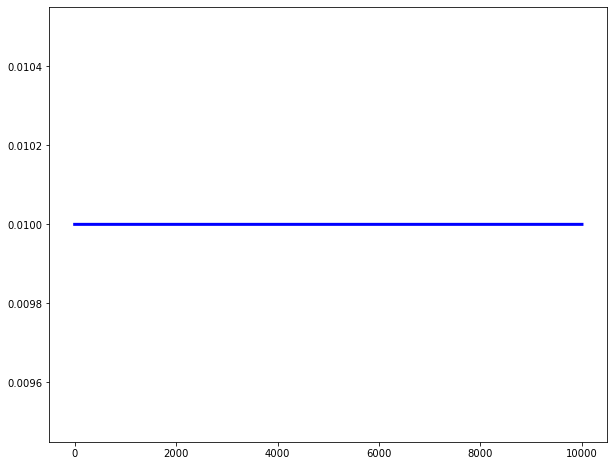

In [9]:
plt.figure(figsize=([10,8]))
ax=plt.plot(axis, eta_vec, 'b', linewidth=3,label='Exponential')
plt.plot(axis, eta_veclin, 'r', linewidth=3,label='Linear')
plt.plot(axis, eta_vecns, 'g', linewidth=3,label='Constant')
plt.grid()
plt.legend(fontsize=20)
plt.ylabel(r'$\eta$',fontsize=20)
plt.xlabel('Number of epochs',fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=20,pad=5)
plt.tick_params(axis='y', which='major', labelsize=20,pad=5)
plt.ylim([1e-6, 1.1e-2])
save_fig('exp_eta')
plt.show()


# Ridge regression and tunning $\lambda$ and $\eta$

In [11]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

lr = lreg.LinearReg()

# Generate noise and add it to Franke function
zz_0     = lr.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = lr.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = lr.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
X_train = lr.DesignDesign(x_train,y_train,degree)  
X_test  = lr.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Set the learning rate, the number of iterations, and the regulirization parameter
nxy        = X_train.shape[0]
n_eta      = [0.00001, 0.0001, 0.001, 0.01]
n_lamb     = [0.0, 1e-4, 1e-3, 1e-2]
epochs     = 10000
batch_size = 300

nk               = 5
z_folds, x_folds = lr.k_fold_reshaper(nk,z_train,X_train,shuffle=True)
MSE_SGD_train    = np.zeros((len(n_eta), len(n_lamb)))
MSE_SGD_test     = np.zeros((len(n_eta), len(n_lamb)))
R2_SGD_train     = np.zeros((len(n_eta), len(n_lamb)))
R2_SGD_test      = np.zeros((len(n_eta), len(n_lamb)))

for k in range(nk):
    
    xk_train = x_folds[np.arange(len(x_folds))!=k]      
    xk_train = np.concatenate(xk_train,axis=0)
    zk_train = z_folds[np.arange(len(z_folds))!=k]
    zk_train = np.concatenate(zk_train,axis=0)
    xk_test  = x_folds[k]
    zk_test  = z_folds[k]
    jc       = 0

    for j in n_lamb:
    
        ic = 0
    
        for i in n_eta:
            
            lr = lreg.LinearReg(eta = i,lamb = j, eta_type ='linear',eta_scal=True)
 
            cost_test, cost_train, axis, beta_GD, eta_vec = lr.fit(xk_train, zk_train, xk_test, 
                                              zk_test, Niter = epochs, batch_size = batch_size,solver='sgd')
            pred_SGD_test  = lr.predict(xk_test)
            pred_SGD_train = lr.predict(xk_train)  
        
            MSE_test  = lr.MSE(zk_test,pred_SGD_test)
            MSE_train = lr.MSE(zk_train,pred_SGD_train)
            R2_test   = lr.R2Score(zk_test,pred_SGD_test)
            R2_train  = lr.R2Score(zk_train,pred_SGD_train)
        
            MSE_SGD_train[ic,jc] += MSE_train
            MSE_SGD_test[ic,jc]  += MSE_test
            R2_SGD_train[ic,jc]  += R2_train
            R2_SGD_test[ic,jc]   += R2_test
            ic                   += 1
            
        jc += 1
        
MSE_SGD_train  = MSE_SGD_train/nk
MSE_SGD_test   = MSE_SGD_test/nk   
R2_SGD_train   = R2_SGD_train/nk
R2_SGD_test    = R2_SGD_test/nk  

In [ ]:
bb = np.array(n_eta)
ee = np.array(n_lamb)

bbin, eein = np.where(MSE_SGD_test  == np.min(MSE_SGD_test))
best_mbatch,best_epoch              = bb[bbin], ee[eein] 
bbin2, eein2 = np.where(R2_SGD_test == np.max(R2_SGD_test))
best_mbatch2,best_epoch2            = bb[bbin2], ee[eein2] 

print('MSE best = ',best_mbatch,best_epoch)
print('R2 best = ',best_mbatch2,best_epoch2)

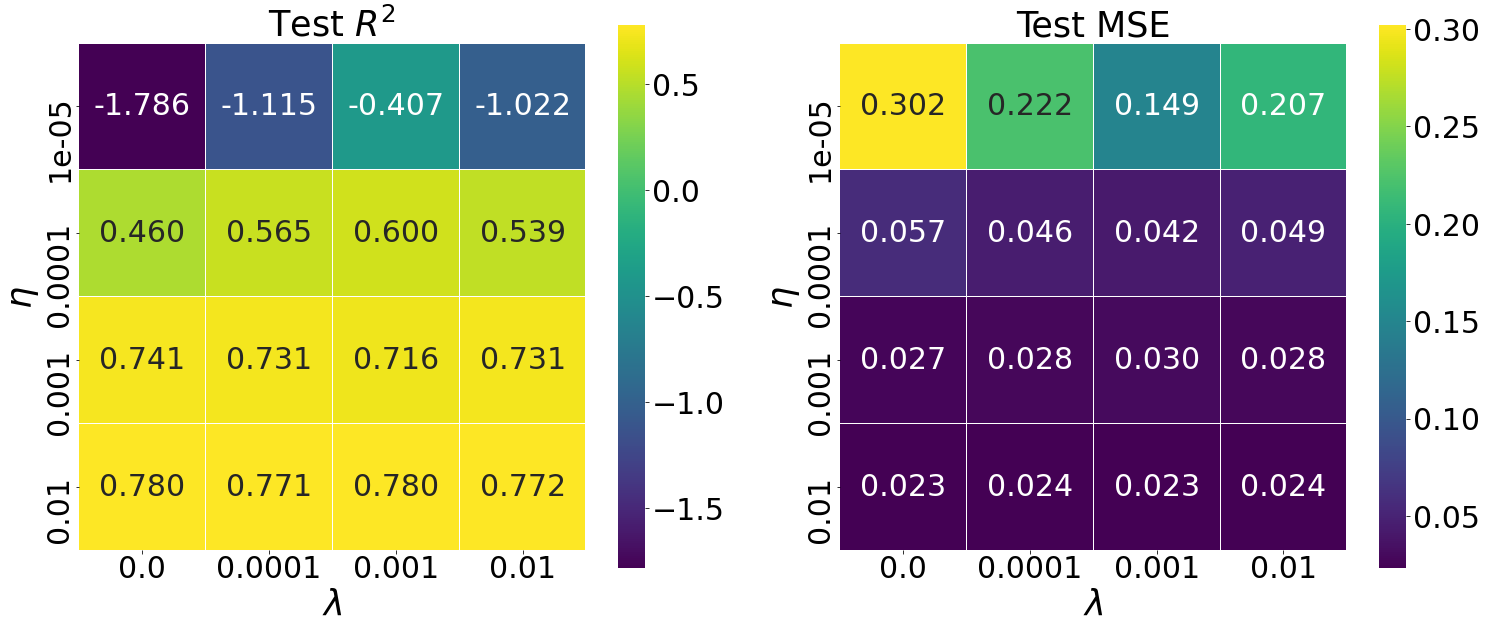

In [12]:
yticklabels = n_eta
xticklabels = n_lamb

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(R2_SGD_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = r'Test $R^2$'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(MSE_SGD_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test MSE'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
#save_fig('LinearReg_CV_exp_eta_lamb_SGD')
save_fig('LinearReg_CV_linear_eta_lamb_SGD')
#save_fig('LinearReg_CV_const_eta_lamb_SGD')
plt.show()

# SGD using Scikit-learn

In [13]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

lr = lreg.LinearReg()

# Generate noise and add it to Franke function
zz_0     = lr.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = lr.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = lr.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.ravel()
z_test   = zz_test.ravel()

# Creating design matrix, extracting beta and predicting 
X_train = lr.DesignDesign(x_train,y_train,degree)  
X_test  = lr.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Set the learning rate, the number of iterations, and the regulirization parameter
nxy        = X_train.shape[0]
n_eta      = [0.00001, 0.0001, 0.001, 0.01]
n_lamb     = [0.0, 1e-4, 1e-3, 1e-2]
epochs     = 10000
batch_size = 300

nk               = 5
z_folds, x_folds = lr.k_fold_reshaper(nk,z_train,X_train,shuffle=True)
MSE_SGD_train    = np.zeros((len(n_eta), len(n_lamb)))
MSE_SGD_test     = np.zeros((len(n_eta), len(n_lamb)))
R2_SGD_train     = np.zeros((len(n_eta), len(n_lamb)))
R2_SGD_test      = np.zeros((len(n_eta), len(n_lamb)))

for k in range(nk):
    
    xk_train = x_folds[np.arange(len(x_folds))!=k]      
    xk_train = np.concatenate(xk_train,axis=0)
    zk_train = z_folds[np.arange(len(z_folds))!=k]
    zk_train = np.concatenate(zk_train,axis=0)
    xk_test  = x_folds[k]
    zk_test  = z_folds[k]
    jc       = 0

    for j in n_lamb:
    
        ic = 0
    
        for i in n_eta:
            
            SGD_sk = SGDRegressor(max_iter = epochs, penalty='l2', alpha=j, eta0=i)
            SGD_sk.fit(xk_train,zk_train)
            
            pred_SGD_test  = SGD_sk.predict(xk_test)
            pred_SGD_train = SGD_sk.predict(xk_train)  
        
            MSE_test  = mean_squared_error(zk_test,pred_SGD_test)
            MSE_train = mean_squared_error(zk_train,pred_SGD_train)
            R2_test   = r2_score(zk_test,pred_SGD_test)
            R2_train  = r2_score(zk_train,pred_SGD_train)
        
            MSE_SGD_train[ic,jc] += MSE_train
            MSE_SGD_test[ic,jc]  += MSE_test
            R2_SGD_train[ic,jc]  += R2_train
            R2_SGD_test[ic,jc]   += R2_test
            ic                   += 1
            
        jc += 1
        
MSE_SGD_train  = MSE_SGD_train/nk
MSE_SGD_test   = MSE_SGD_test/nk   
R2_SGD_train   = R2_SGD_train/nk
R2_SGD_test    = R2_SGD_test/nk 

#print('MSE SGD TEST',MSE_SGD_test)
#print('MSE SGD TRAIN',MSE_SGD_train)
#
#print('R2 SGD TEST',R2_SGD_test)
#print('R2 SGD TRAIN',R2_SGD_train)


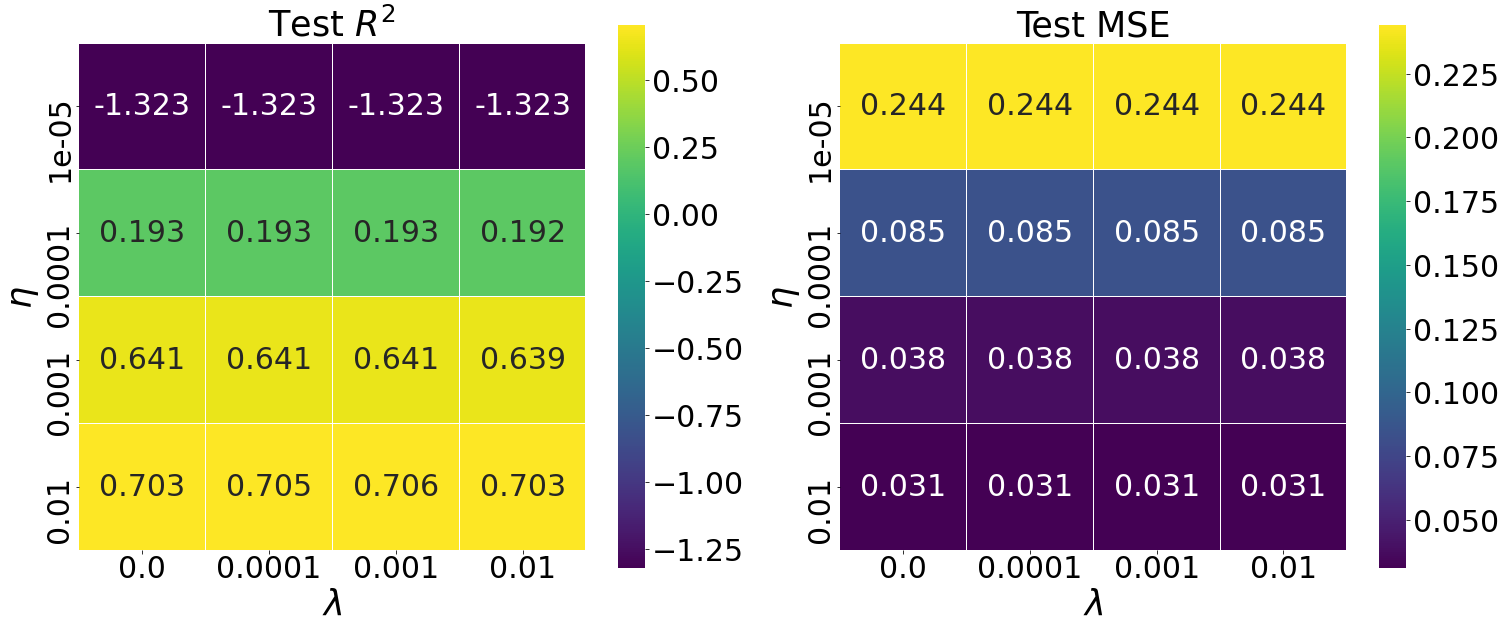

In [15]:
yticklabels = n_eta
xticklabels = n_lamb

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(R2_SGD_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = r'Test $R^2$'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(MSE_SGD_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test MSE'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
#save_fig('LinearReg_Sklearn_exp_eta_lamb_SGD')
#save_fig('LinearReg_Sklearn_const_eta_lamb_SGD')
plt.show()

## Analytical Vs SGD

In [18]:
# Make data using rand function
np.random.seed(2020)
degree = 5                
npar   = int((degree+1)*(degree+2)/2)
n_samp = int(2*npar/0.8)
x      = (np.random.uniform(0, 1, n_samp))
y      = (np.random.uniform(0, 1, n_samp))
x1     = (np.random.uniform(0, 1, n_samp))
y1     = (np.random.uniform(0, 1, n_samp))

# split into training and test data
n_test  = int(0.2*n_samp)
n_train = n_samp - n_test
x_test  = np.sort(x1[:n_test])
y_test  = np.sort(y1[:n_test])
x_train = np.sort(x[n_test:])
y_train = np.sort(y[n_test:])

# Meshgrid x and y to create a surface
xx_train, yy_train = np.meshgrid(x_train,y_train)
xx_test, yy_test   = np.meshgrid(x_test,y_test)

lr = lreg.LinearReg()

# Generate noise and add it to Franke function
zz_0     = lr.FrankeFunction(xx_train, yy_train, 0)
nsig     = 0.1*np.max(np.abs(zz_0))
zz_train = lr.FrankeFunction(xx_train, yy_train, nsig)
zz_test  = lr.FrankeFunction(xx_test, yy_test, nsig)
z_train  = zz_train.reshape(-1,1)
z_test   = zz_test.reshape(-1,1)

# Creating design matrix, extracting beta and predicting 
X_train = lr.DesignDesign(x_train,y_train,degree)  
X_test  = lr.DesignDesign(x_test,y_test,degree)

# Scaling
X_train_int = X_train[:,0]
X_test_int  = X_test[:,0]
X_train     = X_train[:,1:]
X_test      = X_test[:,1:]
scaler      = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.c_[X_train_int,X_train]
X_test  = np.c_[X_test_int,X_test]

# Set the learning rate, the number of iterations, and the regulirization parameter
nxy        = X_train.shape[0]
eta        = 0.01
lamb       = 1e-3
epochs     = 10000
batch_size = 300

lr = lreg.LinearReg(eta = eta, lamb=lamb, eta_type ='linear',eta_scal=True)
cost_test, cost_train, axis, beta_SGD, _ = lr.fit(X_train, z_train, X_test, z_test, Niter=epochs,
                                                 batch_size=batch_size, solver='sgd')
        
pred_SGD_test  = lr.predict(X_test)
pred_SGD_train = lr.predict(X_train)  
        
MSE_test  = lr.MSE(z_test,pred_SGD_test)
MSE_train = lr.MSE(z_train,pred_SGD_train)
R2_test   = lr.R2Score(z_test,pred_SGD_test)
R2_train  = lr.R2Score(z_train,pred_SGD_train)
        
beta_OLS, pred_OLS_test, pred_OLS_train       = lr.OridinaryLeastSquares(X_train,z_train,X_test)   
beta_Ridge, pred_Ridge_test, pred_Ridge_train = lr.RidgeRegression(X_train,z_train,X_test,lamb)  
    
MSE_test_OLS  = lr.MSE(z_test,pred_OLS_test)
MSE_train_OLS = lr.MSE(z_train,pred_OLS_train)
R2_test_OLS   = lr.R2Score(z_test,pred_OLS_test)
R2_train_OLS  = lr.R2Score(z_train,pred_OLS_train)

MSE_test_Ridge  = lr.MSE(z_test,pred_Ridge_test)
MSE_train_Ridge = lr.MSE(z_train,pred_Ridge_train)
R2_test_Ridge   = lr.R2Score(z_test,pred_Ridge_test)
R2_train_Ridge  = lr.R2Score(z_train,pred_Ridge_train)

In [19]:
print('MSE SGD TEST',MSE_test)
print('R2 SGD TEST',R2_test)

print('MSE OLS TEST',MSE_test_OLS)
print('R2 OLS TEST',R2_test_OLS)

print('MSE Ridge TEST',MSE_test_Ridge)
print('R2 Ridge TEST',R2_test_Ridge)

MSE SGD TEST 0.020516678058230275
R2 SGD TEST 0.7421970103707811
MSE OLS TEST 0.01772611073063842
R2 OLS TEST 0.7772619754578658
MSE Ridge TEST 0.01667917860736374
R2 Ridge TEST 0.7904172353178219
